In [2]:
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import pathlib as Path
import json

def find_json_file(directory):
    """
    Find a JSON file in a directory (and its subdirectories) and load it into a dictionary.
    
    Parameters:
        directory (str): Path to the directory to search.
    
    Returns:
        dict or None: Dictionary containing the JSON data if a file is found, 
                      None otherwise.
    """
    for root, dirs, files in os.walk(directory):
        for file_name in files:
            if file_name.endswith('.json'):
                file_path = os.path.join(root, file_name)
                with open(file_path, 'r') as file:
                    try:
                        json_data = json.load(file)
                        return json_data
                    except json.JSONDecodeError:
                        print(f"Error: JSON decode failed for file '{file_path}'")
    print("No JSON file found in the directory.")
    return None


# Path
dir_path = r"C:\Users\arpan\OneDrive\Documents\GRB\data\DCL_ds0"   

# Check if the path exists
if os.path.exists(dir_path):
    print(f"The path '{dir_path}' exists.")
else:
    print(f"The path '{dir_path}' does not exist.")


# importing data
event_types = {1:'GRB',2:'TGF',3:'SGR',4:'SFLARE'}

test_dir = os.path.join(dir_path,"test")  
train_dir = os.path.join(dir_path,"train")

# Replace 'your_search_string' with the string you are looking for in file names
search_string = 'bn'

search_pattern = os.path.join(test_dir, f'*{search_string}*')
test_files = glob.glob(search_pattern)

search_pattern = os.path.join(train_dir, f'*{search_string}*')
train_files = glob.glob(search_pattern)

json_data = find_json_file(dir_path)
print(json_data)

dno = json_data['number of data points']

try:
    inup = json_data['include unprocessed']
except:
    inup = False
try:
    chrn = json_data['channel ranges']
except:
    chrn = 1
    
try:
    t = json_data['time interval'][1]-json_data['time interval'][0]
except:
    t='n/a'
    
# Calculating the number of points in each binnning
bin_list = json_data['bin list']
extra = 2 if inup else 1
dno_list = (len(bin_list)) * (len(chrn)*extra)  * [dno]
data_total = sum(dno_list)

fileno = 98
# Open the file in read mode
with open(train_files[fileno], 'r') as file:
    # Read all lines into a list
    lines = file.readlines()
print('hello',train_files[fileno],len(lines))

check_data = np.loadtxt(train_files[fileno], delimiter=' ').astype(np.int32)
len_data = len(check_data)

print(dno_list)
if data_total == len_data and len(dno_list) == (len(bin_list)) * (len(chrn)*extra):
    print('bin edges calculated correctly')
    print(data_total)
    print(len_data)
else:
    print('inconsistency in bin edges calculated and data')
    print(data_total)
    print(len_data)
    
print('channel range no',chrn)
print('number of data points',dno)
print('time interval',t)



def process_file(file, X,Y,event_counter,inup = inup, dno_list = dno_list):
    """
    takes a file and processes it and adds it to the data set
    file:path to the file to be processed
    X:data set to be added to
    Y:list of labels of data
    dno_list:list of number of data points in each binning as calculated previously
    
    returns updated X and Y and event_counter
    """
    # fetching data from file and checking if label is considered
    event_type , event_name = file.split('/')[-1].split('_')
    loaded_data = np.loadtxt(file, delimiter='\t').astype(np.float32)
    if event_type not in event_counter.keys():
        return X,Y,event_counter
    
    y = [0,0,0,0]
    
    # setting and updating Y
    for key,value in event_types.items():
        if value in file.split('\\')[-1]:
            y[key-1] = 1
            Y.append(y)
            event_counter[value] += 1
            
    extra = 2 if inup else 1
    
    # setting and updating X
    f = 0
    for k,dno in zip(X.keys(),dno_list):
        datlist = []
        for i in range(len(chrn) * extra):
            datlist.append(loaded_data[f:f+dno])
            f = f + int(dno)
#         print(len(datlist))
        X[k].append(np.array(datlist).transpose())
        
    return X,Y,event_counter

# initializing train and test sets
X_train = {str(key): [] for key in bin_list}
Y_train = []
train_event_counter = {'GRB':0,'TGF':0,'SGR':0,'SFLARE':0}

X_test = {str(key): [] for key in bin_list}
Y_test = []
test_event_counter = {'GRB':0,'TGF':0,'SGR':0,'SFLARE':0}

print(process_file(train_files[1],X_train,Y_train,train_event_counter))

# processing train and test data sets
for file in train_files[:]:
    X_train,Y_train,train_event_counter = process_file(file,X_train,Y_train,train_event_counter)
print('training events\n',train_event_counter)
print('total events : ', sum([i for i in train_event_counter.values()]))
Y_train = np.array(Y_train)
print('shape of Y_train', Y_train.shape)
print('shape of X_train dictionary:')
for i in X_train.keys():
    X_train[i] = np.array(X_train[i])
#     X_train[i] = np.reshape(X_train[i], X_train[i].shape + tuple([1]))
    print(type(X_train[i]),X_train[i].shape)

for file in test_files[:]:
    X_test,Y_test,test_event_counter = process_file(file,X_test,Y_test,test_event_counter)
print('testing events\n',test_event_counter)
print('total events : ', sum([i for i in test_event_counter.values()]))
Y_test = np.array(Y_test)
print('shape of Y_test', Y_test.shape)
print('shape of X_test dictionary:')
for i in X_test.keys():
    X_test[i] = np.array(X_test[i])
#     X_test[i] = np.reshape(X_test[i], X_test[i].shape + tuple([1]))
    print(type(X_test[i]),X_test[i].shape)




The path 'C:\Users\arpan\OneDrive\Documents\GRB\data\DCL_ds0' exists.
{'bin list': [0.001, 0.005, 0.01, 0.1, 0.5, 1, 5], 'time interval': 'n/a', 'number of data points': 499, 'data set name': 'DCL_ds0', 'data set path': 'C:\\Users\\arpan\\OneDrive\\Documents\\GRB\\data\\DCL_ds0', 'channel ranges': [[3, 50], [51, 124]], 'ratio': 0.25}
[499, 499, 499, 499, 499, 499, 499, 499, 499, 499, 499, 499, 499, 499]
bin edges calculated correctly
6986
6986
channel range no 2
number of data points 499
time interval n/a
testing events
 {'GRB': 200, 'TGF': 200, 'SGR': 184, 'SFLARE': 200}
total events :  784
shape of Y_test (784, 4)
shape of X_test dictionary:
<class 'numpy.ndarray'> (784, 499, 2)
<class 'numpy.ndarray'> (784, 499, 2)
<class 'numpy.ndarray'> (784, 499, 2)
<class 'numpy.ndarray'> (784, 499, 2)
<class 'numpy.ndarray'> (784, 499, 2)
<class 'numpy.ndarray'> (784, 499, 2)
<class 'numpy.ndarray'> (784, 499, 2)


In [3]:
# Load the model
from keras.models import load_model
model_path = r"C:\Users\arpan\OneDrive\Desktop\saved models\old bins 1\DCL.keras"
model = load_model(model_path)

In [6]:
# Select the threshold value using training data

def analyze_predictions(predicted_values, true_values):
    correct_confidences = []
    incorrect_confidences = []
    
    for pred, true in zip(predicted_values, true_values):
        predicted_class = np.argmax(pred)
        true_class = np.argmax(true)
        confidence = np.max(pred)
        
        if predicted_class == true_class:
            correct_confidences.append(confidence)
        else:
            incorrect_confidences.append(confidence)
    
    avg_correct_confidence = np.mean(correct_confidences) if correct_confidences else 0
    avg_incorrect_confidence = np.mean(incorrect_confidences) if incorrect_confidences else 0
    
    return avg_correct_confidence, avg_incorrect_confidence

avg_correct, avg_incorrect = analyze_predictions(model.predict(X_train), Y_test)

print(f"Average confidence for correct predictions: {avg_correct:.4f}")
print(f"Average confidence for incorrect predictions: {avg_incorrect:.4f}")

threshold = (avg_correct + avg_incorrect)/2

Average confidence for correct predictions: 0.9477
Average confidence for incorrect predictions: 0.7770


In [4]:
# Make predictions
y_pred = model.predict(X_test)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

Accuracy on training data with unidentified class: 0.7678571428571429


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Yes
Accuracy on test data with unidentified class: 0.7678571428571429
Number of unidentified instances in training data: 138
Number of unidentified instances in test data: 138
confusion matrix


<Figure size 1000x700 with 0 Axes>

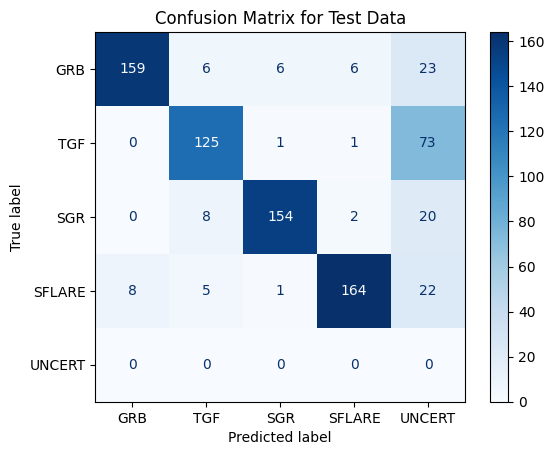

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np


def predict_with_unidentified(model, data, threshold=0.4):
    predictions = model.predict(data)
    max_prob = np.max(predictions, axis=1)
    labels = np.argmax(predictions, axis=1)
    labels[max_prob < threshold] = 4
    
    unidentified_count = np.sum(max_prob < threshold)
    return labels, unidentified_count

# Evaluate on training data
train_predictions, train_unidentified_count = predict_with_unidentified(model, X_test, threshold)
train_accuracy = np.mean(train_predictions == np.argmax(Y_test, axis=1))
print(f'\nAccuracy on training data with unidentified class: {train_accuracy}\n\n')

# Evaluate on validation data
test_predictions, test_unidentified_count = predict_with_unidentified(model, X_test, threshold)

# Check if Y_test is one-hot encoded or not
if Y_test.ndim > 1:
    print("Yes")
    test_true_labels = np.argmax(Y_test, axis=1)
else:
    test_true_labels = Y_test

test_accuracy = np.mean(test_predictions == test_true_labels)
print(f'Accuracy on test data with unidentified class: {test_accuracy}')

print(f'Number of unidentified instances in training data: {train_unidentified_count}')
print(f'Number of unidentified instances in test data: {test_unidentified_count}')

print("confusion matrix")
conf_matrix = confusion_matrix(test_true_labels, test_predictions, labels=[0, 1, 2, 3, 4])

plt.figure(figsize=(10, 7))
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['GRB', 'TGF', 'SGR', 'SFLARE', 'UNCERT'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Test Data')
plt.show()

In [7]:
def analyze_predictions_with_threshold(predicted_values, true_values, confidence_threshold):
    confidently_right = 0
    confidently_wrong = 0
    uncertain = 0
    total = len(predicted_values)
    
    for pred, true in zip(predicted_values, true_values):
        predicted_class = np.argmax(pred)
        true_class = np.argmax(true)
        confidence = np.max(pred)
        
        if confidence >= confidence_threshold:
            if predicted_class == true_class:
                confidently_right += 1
            else:
                confidently_wrong += 1
        else:
            uncertain += 1
    
    percent_confidently_right = (confidently_right / total) * 100
    percent_confidently_wrong = (confidently_wrong / total) * 100
    percent_uncertain = (uncertain / total) * 100
    
    return percent_confidently_right, percent_confidently_wrong, percent_uncertain

confidence_threshold = 0.8

percent_right, percent_wrong, percent_uncertain = analyze_predictions_with_threshold(y_pred, Y_test, confidence_threshold)

print(f"Percentage of confidently right predictions: {percent_right:.2f}%")
print(f"Percentage of confidently wrong predictions: {percent_wrong:.2f}%")
print(f"Percentage of uncertain predictions: {percent_uncertain:.2f}%")

Percentage of confidently right predictions: 76.79%
Percentage of confidently wrong predictions: 5.61%
Percentage of uncertain predictions: 17.60%


In [ ]:
# prob distributions
# class specific threshold